<a href="https://colab.research.google.com/github/fernandojunior/deteccao-fraude/blob/master/src/Fraud_Detection_Xente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark load lib

In [1]:
'''!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install pandas_ml
!pip install -q findspark
!pip install catboost
!pip install -U imbalanced-learn
!pip install pyod seaborn catboost plotly_express==0.4.0
!pip install --upgrade pyod
!pip install shap
!pip install --user --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension
#!pip install -r requirements.txt

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"
'''
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('xente').getOrCreate()
spark

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pyspark.sql.functions as F
import shap
import catboost
from catboost import Pool, CatBoostClassifier, cv

from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql.functions import mean, udf, array, col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                              f1_score, precision_score, recall_score, roc_curve, roc_auc_score)
from pyspark.sql.functions import (mean, dayofmonth, hour, count, udf, 
                                                                   month, weekofyear, dayofyear, array,
                                                                   format_number, date_format, col, round)

# Load Training Data

In [2]:
def read_data_from_web(url):
  data = pd.read_csv(url)
  spark_data = spark.createDataFrame(data)
  return spark_data

#fraud_data = read_data_from_web("https://drive.google.com/uc?export=download&id=1NrtVkKv8n_g27w5elq9HWZA1i8aFBW0G")
fraud_data = spark.read.csv('training.csv', inferSchema=True, header=True)
df_backup = fraud_data

In [286]:
fraud_data = df_backup

# Data Preprocessing

## Creating Features

In [287]:
fraud_data = fraud_data.withColumn("Operation", F.when(fraud_data.Amount > 0, 1).when(fraud_data.Amount < 0, -1).otherwise(0))
fraud_data = fraud_data.withColumn('PositiveAmount', F.abs(fraud_data['Amount']))
fraud_data = fraud_data.withColumn('Hour', hour(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('DayOfYear', dayofyear(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('WeekOfYear', weekofyear(fraud_data['TransactionStartTime']))
fraud_data = fraud_data.withColumn('Month', month(fraud_data['TransactionStartTime']))

In [288]:
def get_features_augmentation(df, items_list, clean=False):
  gen_train_data = df.filter('FraudResult == 0')

  for item in items_list:
    mean_column_name = 'avg_ps_{0}'.format(item)
    mean_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).mean()
    mean_aux = mean_aux.select(col(item), col('avg(PositiveAmount)').alias(mean_column_name))
    df = df.join(mean_aux, on=item)

    min_column_name = 'min_ps_{0}'.format(item)
    min_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).min()    
    min_aux = min_aux.select(col(item), col('min(PositiveAmount)').alias(min_column_name))
    df = df.join(min_aux, on=item)

    max_column_name = 'max_ps_{0}'.format(item)
    max_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).max()    
    max_aux = max_aux.select(col(item), col('max(PositiveAmount)').alias(max_column_name))
    df = df.join(max_aux, on=item)
    
    mean_pi_column_name = 'pi_{0}'.format(item)
    mean_pi = gen_train_data.select([item,'PricingStrategy']).groupBy(item).mean()
    mean_pi = mean_pi.select(col(item), col('avg(PricingStrategy)').alias(mean_pi_column_name))
    df = df.join(mean_pi, on=item)
    
    ratio_column_name = 'rt_avg_ps_{0}'.format(item)
    df = df.withColumn(ratio_column_name, (F.col('PositiveAmount')-F.col(mean_column_name))/ F.col(mean_column_name))

  if clean:
    df = clean_data(df)
  
  return df

In [289]:
fraud_data = get_features_augmentation(fraud_data, 
                                       ['AccountId', 'ChannelId', 'ProductCategory', 'ProductId', 
                                        'Hour', 'DayOfYear', 'WeekOfYear', 'Month'])

## Cleaning Unuseful Features

In [192]:
# data: dataframe - columns: column list to remove
def remove_feature(data, columns_in):
  return data.drop(*columns_in)

In [193]:
def clean_data(fraud_data, columns_to_remove):
  fraud_data = remove_feature(fraud_data, columns_to_remove)
  return fraud_data

In [290]:
fraud_data = clean_data(fraud_data, columns_to_remove = ['Amount','TransactionStartTime','BatchId','SubscriptionId',
                                                                                                                 'TransactionId','AccountId','CustomerId','ProviderId',
                                                                                                                 'ProductCategory','CurrencyCode','CountryCode'])

## Features

In [291]:
all_features = ['ChannelId','ProductId','PricingStrategy','Value','Operation', 'PositiveAmount',
                            'Hour', 'DayOfYear', 'WeekOfYear', 'Month',
                            'avg_ps_Hour','min_ps_Hour','max_ps_Hour','rt_avg_ps_Hour',
                            'avg_ps_DayOfYear','min_ps_DayOfYear','max_ps_DayOfYear','rt_avg_ps_DayOfYear',
                            'avg_ps_WeekOfYear','min_ps_WeekOfYear','max_ps_WeekOfYear','rt_avg_ps_WeekOfYear',#0-21
                            'avg_ps_Month','min_ps_Month','max_ps_Month','rt_avg_ps_Month',
                            'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                            'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                            'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                            'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId',#41
                            'pi_Hour','pi_DayOfYear','pi_WeekOfYear','pi_Month',
                            'pi_AccountId','pi_ChannelId','pi_ProductCategory','pi_ProductId']

label = 'FraudResult'

In [292]:
categorical_features = ['ChannelId','ProductId','PricingStrategy']
categorical_features_dims = [fraud_data.toPandas().columns.get_loc(i) for i in categorical_features[:]] 
categorical_features_dims

[5, 4, 7]

In [293]:
numerical_features = ['PricingStrategy','Value','Operation', 'PositiveAmount',
                            'Hour', 'DayOfYear', 'WeekOfYear', 'Month',
                            'avg_ps_Hour','min_ps_Hour','max_ps_Hour','rt_avg_ps_Hour',
                            'avg_ps_DayOfYear','min_ps_DayOfYear','max_ps_DayOfYear','rt_avg_ps_DayOfYear',
                            'avg_ps_WeekOfYear','min_ps_WeekOfYear','max_ps_WeekOfYear','rt_avg_ps_WeekOfYear',#0-21
                            'avg_ps_Month','min_ps_Month','max_ps_Month','rt_avg_ps_Month',
                            'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                            'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                            'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                            'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId',#41
                            'pi_Hour','pi_DayOfYear','pi_WeekOfYear','pi_Month',
                            'pi_AccountId','pi_ChannelId','pi_ProductCategory','pi_ProductId']
numerical_features_dims = [fraud_data.toPandas().columns.get_loc(i) for i in numerical_features[:]] 
numerical_features_dims

KeyboardInterrupt: 

## Outlier Analysis

In [201]:
sns.set(rc={'figure.figsize':(5, 10)})

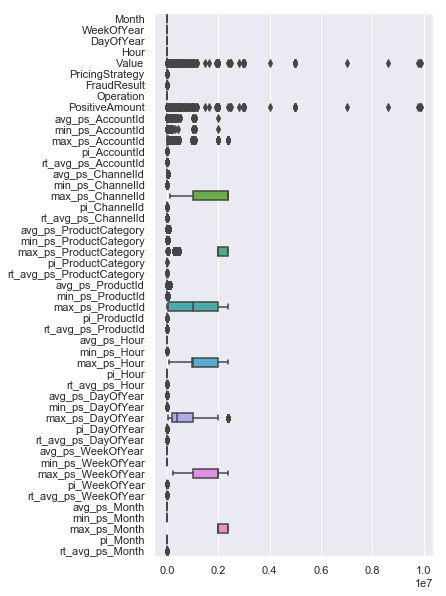

In [202]:
sns.boxplot(data=fraud_data.toPandas(), orient="h")

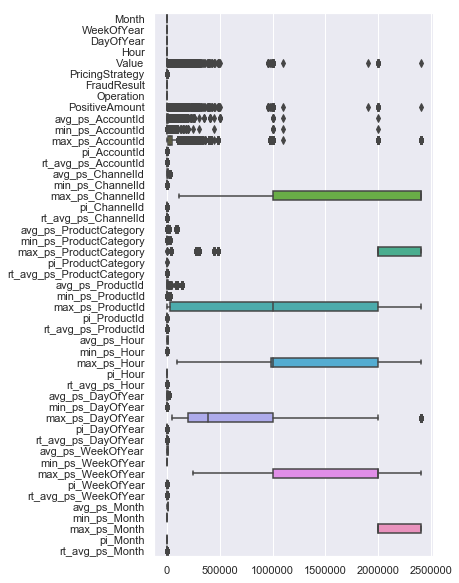

In [33]:
sns.boxplot(data=fraud_data.filter('FraudResult == 0').toPandas(), orient="h")

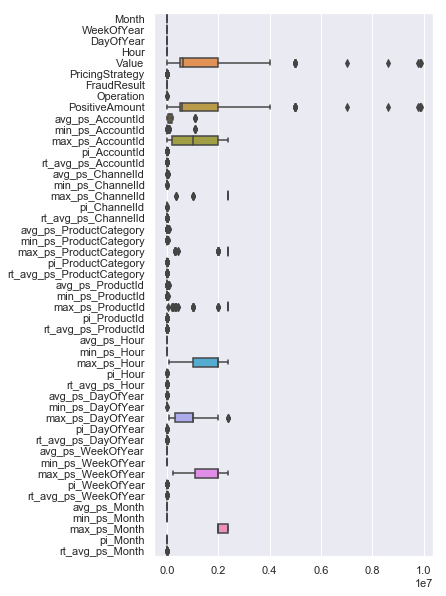

In [34]:
sns.boxplot(data=fraud_data.filter('FraudResult == 1').toPandas(), orient="h")

# Isolation Forest

In [35]:
def split_dataset_convertingToPandas(df, features, label):
  df_x = df.select(features).toPandas()
  df_y = df.select(label).toPandas()

  X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)
  return X_train, X_test, y_train, y_test

In [36]:
X_train, X_test, y_train, y_test = split_dataset_convertingToPandas(fraud_data, numerical_features, label)
X_outliers = fraud_data.filter('FraudResult==1').select(numerical_features).toPandas()

## Isolation Forest Predictions and precision analysis

In [37]:
# Input:
# TP | FP
# FN | TN

# Output:
#   F1-score
def compute_f1score(data):
  tp = data[0][0]
  fp = data[0][1]
  fn = data[1][0]
  tn = data[1][1]
  # sensitivity, recall, hit rate, or true positive rate (TPR)
  tpr = tp / (tp+fn)
  # precision or positive predictive value (PPV)
  ppv = tp / (tp+fp)
  # F1 score is the harmonic mean of precision and sensitivity
  f1_score = 2 * (ppv*tpr) / (ppv+tpr)
  return f1_score

In [38]:
# Input: Positive=-1 and Negative=1
# Output: Positive=1 and Negative=0
def norm_pred(data):
  data = ((data*-1)+1)/2
  return data

def train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_list, cont_list):
  # fit the model
  rng = np.random.RandomState(42)

  graph_performance = pd.DataFrame([], columns=['f1','max','cont'])

  for max_sample in max_sample_list:
    for cont in cont_list:

      clf = IsolationForest(behaviour='new', max_samples=max_sample,
                            random_state=rng, contamination=cont, n_jobs=10)

      clf.fit(X_train)

      y_pred_train = clf.predict(X_train)
      y_pred_test = clf.predict(X_test)
      y_pred_outliers = clf.predict(X_outliers)

      y_pred_test = norm_pred(y_pred_test)
      y_pred_outliers = norm_pred(y_pred_outliers)

      cm = confusion_matrix(y_test, y_pred_test)
      f1_score = compute_f1score(cm)
  
      new_row = pd.DataFrame({'f1':[f1_score], 'max':[max_sample], 'cont':[cont]})
      graph_performance = graph_performance.append(new_row)
  return graph_performance, clf

In [39]:
def plot_perfomance_clf(perf_arr):
    sns.set(style='darkgrid')
    return sns.lineplot(x='max', y='f1', hue='cont',  data = perf_arr), perf_arr[perf_arr.f1 == perf_arr.f1.max()]

In [40]:
max_sample_arr = np.arange(200, 1000, 200)
contamination_arr = np.arange(.05, .5, .05)

# Balance Data Step

In [41]:
def over_sampler(df, features, label, method):
    X_ = df.select(features).toPandas()
    y_ = df.select(label).toPandas()
    over_sampler = method(random_state=42)
    return over_sampler.fit_resample(X_, y_)

In [42]:
def balance_dataframe_smotenc(data, features, label, categorical_pos):
  sm = SMOTENC(categorical_features=categorical_pos, random_state = 42)
  data_pd = data.toPandas()
  X_train_new, y_train_new = sm.fit_sample(data_pd[features], data_pd[label].ravel())
  X_train_new = pd.DataFrame(X_train_new, columns=all_features)
  y_train_new = pd.DataFrame(y_train_new, columns=[label])
  return X_train_new, y_train_new

In [83]:
X_smotenc, y_smotenc = balance_dataframe_smotenc(fraud_data, all_features, label, categorical_features_dims)

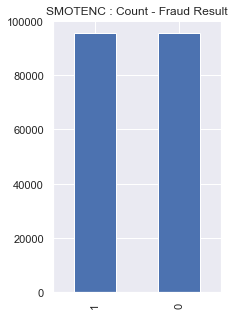

In [84]:
sns.set(rc={'figure.figsize':(3, 5)})
pd.Series(y_smotenc[label]).value_counts().plot.bar(title='SMOTENC : Count - Fraud Result')

## Isolation Forest Evaluation of Oversampling

In [86]:
max_sample_arr = np.arange(200, 1000, 200)
contamination_arr = np.arange(.05, .5, .05)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_smotenc[numerical_features], y_smotenc, test_size=0.3, random_state=42)
X_outliers = X_smotenc[y_smotenc['FraudResult']==1][numerical_features]
smotenc_perfomance_arr, smotenc_clf = train_isolation_forest(X_train, X_test, y_train, y_test, X_outliers, max_sample_arr, contamination_arr)

,f1,max,cont
0,0.705894,200,0.25


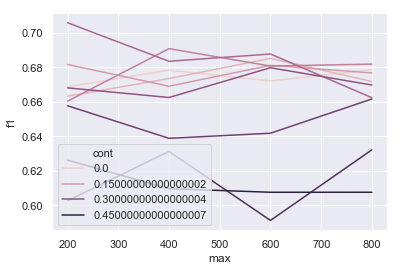

In [89]:
sns.set(rc={'figure.figsize':(6, 4)})
sns.lineplot(x='max', y='f1', hue='cont',  data=smotenc_perfomance_arr)
smotenc_perfomance_arr[smotenc_perfomance_arr.f1 == smotenc_perfomance_arr.f1.max()]

## Add outlier feature estimation

In [ ]:
predictions = smotenc_clf.predict(X_smotenc[numerical_features])
X_smotenc['IsolationForest'] = predictions

In [204]:
all_features.append('IsolationForest')

In [206]:
categorical_features = ['ChannelId','ProductId','PricingStrategy']
categorical_features_dims = [X_smotenc.columns.get_loc(i) for i in categorical_features[:]] 
categorical_features_dims

[0, 1, 2]

In [215]:
numerical_features.append('IsolationForest')
numerical_features_dims = [X_smotenc.columns.get_loc(i) for i in numerical_features[:]] 
numerical_features_dims

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [260]:
X_smotenc.dtypes

ChannelId                    object
ProductId                    object
PricingStrategy              object
Value                        object
Operation                    object
PositiveAmount               object
Hour                         object
DayOfYear                    object
WeekOfYear                   object
Month                        object
avg_ps_Hour                  object
min_ps_Hour                  object
max_ps_Hour                  object
rt_avg_ps_Hour               object
avg_ps_DayOfYear             object
min_ps_DayOfYear             object
max_ps_DayOfYear             object
rt_avg_ps_DayOfYear          object
avg_ps_WeekOfYear            object
min_ps_WeekOfYear            object
max_ps_WeekOfYear            object
rt_avg_ps_WeekOfYear         object
avg_ps_Month                 object
min_ps_Month                 object
max_ps_Month                 object
rt_avg_ps_Month              object
avg_ps_AccountId             object
min_ps_AccountId            

# Catboost Model

In [283]:
model = CatBoostClassifier()

In [217]:
model.fit(X_smotenc, y_smotenc, verbose=False, plot=True, cat_features=categorical_features)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

## Feature Importance

In [218]:
shap.initjs()

shap_values = model.get_feature_importance(Pool(X_smotenc, y_smotenc, cat_features=categorical_features_dims), type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[200,:], X_smotenc.iloc[200,:])

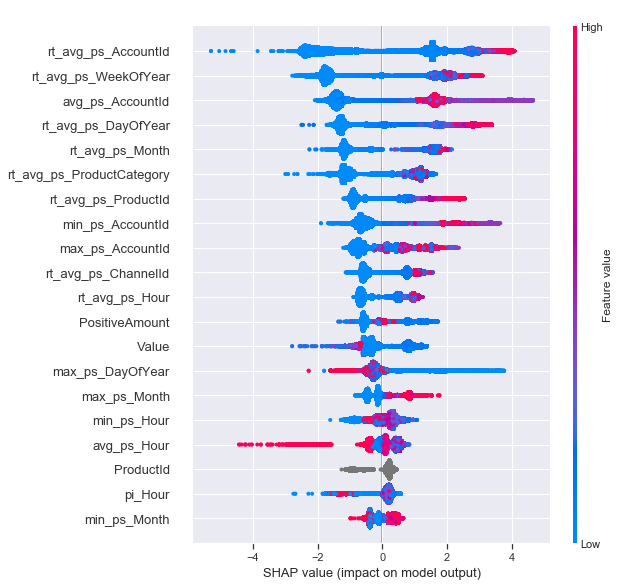

In [220]:
shap.initjs()
# summarize the effects of all the features
shap.summary_plot(shap_values, X_smotenc)

# Evaluation

In [270]:
test_data = read_data_from_web("https://drive.google.com/uc?export=download&id=16cRQIFW6n2th2YOK7DEsp9dQgihHDuHa")
test_backup = test_data
#test_data = spark.read.csv('../data/xente_fraud_detection_test.csv', header=True, inferSchema=True)

In [246]:
test_data = test_data.withColumn("Operation", F.when(test_data.Amount > 0, 1).when(test_data.Amount < 0, -1).otherwise(0))
test_data = test_data.withColumn('PositiveAmount', F.abs(test_data['Amount']))
test_data = test_data.withColumn('Hour', hour(test_data['TransactionStartTime']))
test_data = test_data.withColumn('DayOfYear', dayofyear(test_data['TransactionStartTime']))
test_data = test_data.withColumn('WeekOfYear', weekofyear(test_data['TransactionStartTime']))
test_data = test_data.withColumn('Month', month(test_data['TransactionStartTime']))

In [247]:
def get_features_augmentation_test(df, items_list, clean=False):
  gen_train_data = df

  for item in items_list:
    mean_column_name = 'avg_ps_{0}'.format(item)
    mean_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).mean()
    mean_aux = mean_aux.select(col(item), col('avg(PositiveAmount)').alias(mean_column_name))
    df = df.join(mean_aux, on=item)

    min_column_name = 'min_ps_{0}'.format(item)
    min_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).min()    
    min_aux = min_aux.select(col(item), col('min(PositiveAmount)').alias(min_column_name))
    df = df.join(min_aux, on=item)

    max_column_name = 'max_ps_{0}'.format(item)
    max_aux = gen_train_data.select([item,'PositiveAmount']).groupBy(item).max()    
    max_aux = max_aux.select(col(item), col('max(PositiveAmount)').alias(max_column_name))
    df = df.join(max_aux, on=item)
    
    mean_pi_column_name = 'pi_{0}'.format(item)
    mean_pi = gen_train_data.select([item,'PricingStrategy']).groupBy(item).mean()
    mean_pi = mean_pi.select(col(item), col('avg(PricingStrategy)').alias(mean_pi_column_name))
    df = df.join(mean_pi, on=item)
    
    ratio_column_name = 'rt_avg_ps_{0}'.format(item)
    df = df.withColumn(ratio_column_name, (F.col('PositiveAmount')-F.col(mean_column_name))/ F.col(mean_column_name))

  if clean:
    df = clean_data(df)
  
  return df

In [248]:
test_data = get_features_augmentation_test(test_data,['AccountId', 'ChannelId', 'ProductCategory', 'ProductId', 'Hour', 'DayOfYear', 'WeekOfYear', 'Month'])

In [249]:
test_data = clean_data(test_data, columns_to_remove = ['Amount','TransactionStartTime','BatchId','SubscriptionId',
                                                                                                                 'TransactionId','AccountId','CustomerId','ProviderId',
                                                                                                                 'ProductCategory','CurrencyCode','CountryCode'])

In [250]:
all_features = ['ChannelId','ProductId','PricingStrategy','Value','Operation', 'PositiveAmount',
                            'Hour', 'DayOfYear', 'WeekOfYear', 'Month',
                            'avg_ps_Hour','min_ps_Hour','max_ps_Hour','rt_avg_ps_Hour',
                            'avg_ps_DayOfYear','min_ps_DayOfYear','max_ps_DayOfYear','rt_avg_ps_DayOfYear',
                            'avg_ps_WeekOfYear','min_ps_WeekOfYear','max_ps_WeekOfYear','rt_avg_ps_WeekOfYear',#0-21
                            'avg_ps_Month','min_ps_Month','max_ps_Month','rt_avg_ps_Month',
                            'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                            'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                            'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                            'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId',#41
                            'pi_Hour','pi_DayOfYear','pi_WeekOfYear','pi_Month',
                            'pi_AccountId','pi_ChannelId','pi_ProductCategory','pi_ProductId']

In [251]:
categorical_features = ['ChannelId','ProductId','PricingStrategy']
categorical_features_dims = [test_data.toPandas().columns.get_loc(i) for i in categorical_features[:]] 
categorical_features_dims

[5, 4, 7]

In [252]:
numerical_features = ['PricingStrategy','Value','Operation', 'PositiveAmount',
                            'Hour', 'DayOfYear', 'WeekOfYear', 'Month',
                            'avg_ps_Hour','min_ps_Hour','max_ps_Hour','rt_avg_ps_Hour',
                            'avg_ps_DayOfYear','min_ps_DayOfYear','max_ps_DayOfYear','rt_avg_ps_DayOfYear',
                            'avg_ps_WeekOfYear','min_ps_WeekOfYear','max_ps_WeekOfYear','rt_avg_ps_WeekOfYear',#0-21
                            'avg_ps_Month','min_ps_Month','max_ps_Month','rt_avg_ps_Month',
                            'avg_ps_AccountId','min_ps_AccountId','max_ps_AccountId','rt_avg_ps_AccountId',
                            'avg_ps_ChannelId','min_ps_ChannelId','max_ps_ChannelId','rt_avg_ps_ChannelId',
                            'avg_ps_ProductCategory','min_ps_ProductCategory','max_ps_ProductCategory','rt_avg_ps_ProductCategory',
                            'avg_ps_ProductId','min_ps_ProductId','max_ps_ProductId','rt_avg_ps_ProductId',#41
                            'pi_Hour','pi_DayOfYear','pi_WeekOfYear','pi_Month',
                            'pi_AccountId','pi_ChannelId','pi_ProductCategory','pi_ProductId']
numerical_features_dims = [test_data.toPandas().columns.get_loc(i) for i in numerical_features[:]] 
numerical_features_dims

[7,
 6,
 8,
 9,
 3,
 2,
 1,
 0,
 30,
 31,
 32,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 49,
 10,
 11,
 12,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 24,
 25,
 26,
 27,
 29,
 33,
 38,
 43,
 48,
 13,
 18,
 23,
 28]

In [262]:
test_data_pd = test_data.select(all_features).toPandas()

In [264]:
predictions = smotenc_clf.predict(test_data_pd[numerical_features])
test_data_pd['IsolationForest'] = predictions

In [265]:
test_data_pd.dtypes

ChannelId                     object
ProductId                     object
PricingStrategy                int64
Value                          int64
Operation                      int32
PositiveAmount               float64
Hour                           int32
DayOfYear                      int32
WeekOfYear                     int32
Month                          int32
avg_ps_Hour                  float64
min_ps_Hour                  float64
max_ps_Hour                  float64
rt_avg_ps_Hour               float64
avg_ps_DayOfYear             float64
min_ps_DayOfYear             float64
max_ps_DayOfYear             float64
rt_avg_ps_DayOfYear          float64
avg_ps_WeekOfYear            float64
min_ps_WeekOfYear            float64
max_ps_WeekOfYear            float64
rt_avg_ps_WeekOfYear         float64
avg_ps_Month                 float64
min_ps_Month                 float64
max_ps_Month                 float64
rt_avg_ps_Month              float64
avg_ps_AccountId             float64
m

In [266]:
all_features.append('IsolationForest')

In [267]:
categorical_features = ['ChannelId','ProductId','PricingStrategy']
categorical_features_dims = [test_data_pd.columns.get_loc(i) for i in categorical_features[:]] 
categorical_features_dims

[0, 1, 2]

In [268]:
numerical_features.append('IsolationForest')
numerical_features_dims = [test_data_pd.columns.get_loc(i) for i in numerical_features[:]] 
numerical_features_dims

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50]

In [269]:
test_predictions = model.predict( test_data_pd )

In [276]:
def save_predictions_xente(file_name, transactions_list, predictions_list):
  file = open(file_name,'w')
  file.write('TransactionId,FraudResult\n')
  for (trans_id, value) in zip(transactions_list, predictions_list):
    file.write('{0},{1}\n'.format(trans_id, int(value)))
  file.close()

In [278]:
test_data = test_backup
file_name = 'xento_predictions.csv'  
transactions_list = list(test_data.select('TransactionId').toPandas()['TransactionId'])

In [279]:
save_predictions_xente(file_name, transactions_list, test_predictions)

In [280]:
print("Concluido")

Concluido
